<a id='top'></a>
Let's take a peek into the structure of Dr. Terhonen's data, using a cooccurrence network approach. 

[Python and R setup](#pyset)  
[Data prep](#dataClean)  
[Define cooccurrences](#cooccur)  
[High-disease and low-disease associated fungal OTUS](#cooccurOTUs)  
[Network Statistics](#stats)  

<a id="pyset"></a>
### Python setup

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import networkx, random
from networkx.algorithms import community
import openpyxl
from bokeh.models import MultiLine, Circle, Plot
from bokeh.io import output_file, show
from bokeh.plotting import figure, from_networkx

output_notebook()

NameError: name 'output_notebook' is not defined

### R setup

In [1]:
library(cooccur)

<a id="dataClean)"></a>
### Data prep

Dr. Terhonen has supplied an OTU table. It's big, too big for a spreadsheet gui, really. So get it into memory, and work with it as a pandas df.

In [18]:
## it's big. get it into memory, save it as csv and work with it as a pandas df
wb = openpyxl.load_workbook('Real_Abundance.xlsx')
wb.sheetnames
raw = wb['Sheet1']
eevaOTU = pd.DataFrame(raw.values)
eevaOTU.columns = eevaOTU.iloc[0]
eevaOTU = eevaOTU.drop([0]).reset_index(drop=True)
#eevaOTU.to_csv('eevaOTU.csv')
eevaOTU.iloc[0:3,0:10]

,SampleID,Samplingtime,Growthyear,Diseaseclass,OTU4,OTU428,OTU258,OTU524,OTU491,OTU878
0,10B,June,Year_2018,1,961.413,0,7.55234,0,0,0
1,11B,June,Year_2018,2,579.291,0.699626,9.79477,0,2.09888,0
2,11C,June,Year_2017,2,2152.46,0,16.6534,0,1.38779,0


In [19]:
eevaOTU.shape

(95, 1270)

We are going to do a very simplistic low-disease/high-disease set of comparisons. For the moment we'll drop the other predictors.

In [20]:
lowDisease = eevaOTU['Diseaseclass'].isin([0,1,2]).replace({True:1, False:0})
highDisease = eevaOTU['Diseaseclass'].isin([3,4,5]).replace({True:1, False:0})

eevaOTU.insert(4,"lowDisease",lowDisease)
eevaOTU.insert(5,"highDisease",highDisease)
lowHiDiseaseTable = eevaOTU.drop(columns=['SampleID','Samplingtime','Growthyear','Diseaseclass'])

In [21]:
eevaOTU.iloc[0:3,0:10]

,SampleID,Samplingtime,Growthyear,Diseaseclass,lowDisease,highDisease,OTU4,OTU428,OTU258,OTU524
0,10B,June,Year_2018,1,1,0,961.413,0,7.55234,0
1,11B,June,Year_2018,2,1,0,579.291,0.699626,9.79477,0
2,11C,June,Year_2017,2,1,0,2152.46,0,16.6534,0


I see some funky values in there. Let's make sure that all cells in this are numeric:

In [23]:
for name,i in lowHiDiseaseTable.iterrows():
    bb = i.apply(lambda x: isinstance(x, str))
    if not (i[bb]).empty:
        print(i[bb])
        print(name)


0
OTU4    15722,4745237,614
Name: 4, dtype: object
4


row 4 of OTU4 has three values in it. We are about to convert to presence/absence, so let's just replace with 1. 

In [24]:
lowHiDiseaseTable.loc[4,'OTU4'] = 1

lowHiDiseaseTablePA = (lowHiDiseaseTable > 0).astype(int)

In [29]:
lowHiDiseaseTablePA.iloc[0:5,0:10]

,lowDisease,highDisease,OTU4,OTU428,OTU258,OTU524,OTU491,OTU878,OTU915,OTU954
0,1,0,1,0,1,0,0,0,0,0
1,1,0,1,1,1,0,1,0,0,0
2,1,0,1,0,1,0,1,0,0,0
3,1,0,1,0,1,0,0,0,0,0
4,1,0,1,1,1,0,1,1,0,0


In [ ]:
#lowHiDiseaseTablePA.to_csv('lowHiDiseaseTablePA.csv')

[back to top](#top)

<a id="cooccur"></a>
### Define cooccurrences

We'll use a probabilistic approach, proposed by [Veech et al. (2013)](#https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1466-8238.2012.00789.x), using the R package, [cooccur](#https://www.jstatsoft.org/article/view/v069c02). We'll construct three networks: low-disease samples, high-disease samples, and all (combined) samples. But to reduce clutter, I'll just show the pipeline for one network, from P/A otu table (created above) to adjacency matrix, which is the object which most network analysis software starts from. 

Running the cooccurrence checks on the networks takes several hours on my poor old laptop, so don't recommend running it here unless necessary. Just putting the steps here for posterity. The R data objects that result are saved in the github repo.

In [31]:
## prep low-disease and high-disease matrices with pandas (python)

### low-disease community matrix
lowMask = (lowHiDiseaseTablePA['lowDisease'] == 1)
lowDiseaseTablePA = lowHiDiseaseTablePA[lowMask].drop(columns=['lowDisease', 'highDisease'])
## any lost taxa?
(lowDiseaseTablePA.sum(axis=0) == 0).any() ## yes, some taxa are lost

lostTaxa = (lowDiseaseTablePA.sum(axis=0) == 0)
notLostTaxa = ~(lostTaxa)
lowDiseaseTablePA.loc[:,lostTaxa].shape
lowDiseaseTablePA.loc[:,notLostTaxa].shape
## any all zero sites?
(lowDiseaseTablePA.sum(axis=1) == 0).any() ## nope
## save:
#lowDiseaseTablePA.to_csv('lowDiseaseTablePA.csv')

True

In R kernel, not run here because it takes so long:

In [ ]:
## make low-disease network:

library('cooccur')

## I think we need OTUs as rows, sites as columns, so transpose:
lowDiseaseTablePA <- t(read.csv('lowDiseaseTablePA.csv',
                        header=TRUE, row.names=1))

cooccur.sph.low <- cooccur(mat=lowDiseaseTablePA,
                          type="spp_site",
                          thresh=TRUE,
                          spp_names=TRUE)
save(cooccur.sph.low, file='cooccur.sph.low.rda')


Okay, so we have three sets of cooccurrence results objects. 

We can check these for OTUs that are particularly associated with one disease state or the other. And we can use these to make adjacency matrices for our three networks. First we adjust our p-values for the numerous multiple comparisons involved in networks, in R:

In [7]:
load('cooccur.sph.low.rda')
cooccur.sph.low.results <- cooccur.sph.low$results
## apply bejamini-hochburg to positive cooccurrence p-values
p_gt_adj <- p.adjust(cooccur.sph.low.results$p_gt, method = "BH")
cooccur.sph.low.results$p_gt_adj <- p_gt_adj
## let's keep an FDR of .05 or less:
posMask <- cooccur.sph.low.results$p_gt_adj <= 0.05
cooccur.sph.low.pos <- cooccur.sph.low.results[posMask,]
rownames(cooccur.sph.low.pos) <- NULL
#write.csv(cooccur.sph.low.pos, file="cooccur_sph_low_pos.csv", row.names=FALSE)
head(cooccur.sph.low.pos)

,sp1,sp2,sp1_inc,sp2_inc,obs_cooccur,prob_cooccur,exp_cooccur,p_lt,p_gt,sp1_name,sp2_name,p_gt_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>
1,4,5,16,20,13,0.123,6.3,1.00000,0.00005,OTU524,OTU491,0.01161071
2,11,77,23,35,22,0.309,15.8,1.00000,0.00012,OTU327,OTU218,0.01778587
3,14,738,27,16,14,0.166,8.5,0.99994,0.00083,OTU194,OTU434,0.04459888
4,15,122,7,11,6,0.030,1.5,1.00000,0.00016,OTU789,OTU757,0.02034141
5,18,107,43,37,36,0.612,31.2,1.00000,0.00020,OTU111,OTU246,0.02323523
6,18,326,43,42,40,0.694,35.4,1.00000,0.00012,OTU111,OTU234,0.01778587


Then we go back to pandas in python to code our adjacency matrix, because I love it more than R.

In [9]:
lowPosCooc = pd.read_csv("cooccur_sph_low_pos.csv")
otus = (lowPosCooc.loc[:,'sp1_name'].
        append(lowPosCooc.loc[:,'sp2_name']).
        unique())
matches = lowPosCooc.loc[:,['sp1_name','sp2_name']]
aa = np.zeros(shape = (len(otus),len(otus)), dtype='int')
lowPosAdjacency = pd.DataFrame(data=aa, index = otus, columns = otus)
for _,i in matches.iterrows():
    lowPosAdjacency.loc[i.sp1_name,i.sp2_name] = 1

#lowPosAdjacency.to_csv('lowPosAdjacency.csv')

This gives us our adjacency matrices. They are sparse:

In [8]:
lowPosAdjacency.iloc[1:15,1:15]

,OTU327,OTU194,OTU789,OTU111,OTU279,OTU680,OTU467,OTU152,OTU373,OTU553,OTU264,OTU472,OTU247,OTU421
OTU327,0,0,0,0,0,0,0,0,0,0,0,0,0,0
OTU194,0,0,0,0,0,0,0,0,0,0,0,0,0,0
OTU789,0,0,0,0,0,0,0,0,0,0,0,0,0,0
OTU111,0,0,0,0,0,0,0,0,0,0,0,0,0,0
OTU279,0,0,0,0,0,0,0,0,0,0,0,0,0,0
OTU680,0,0,0,0,0,0,0,0,0,0,0,0,0,0
OTU467,0,0,0,0,0,0,0,0,0,0,0,0,1,0
OTU152,0,0,0,0,0,0,0,0,0,0,0,0,0,0
OTU373,0,0,0,0,0,0,0,0,0,0,0,0,0,0
OTU553,0,0,0,0,0,0,0,0,0,0,0,0,0,0


[back to top](#top)

<a id="cooccurOTUs"></a>
#### High-disease and low-disease associated fungal OTUS

Before we move on, we can check these for OTUs that are associated with the plants that show few or no disease symptoms (disease classes 0-2), and those that tend to associate with plants showing more disease symptoms (disease classes 3-5). This is the main reason we ran a cooccurrence analysis on the entire set of samples.

In [14]:
### low-disease-associated OTUs:
cooccur_combo_pos = pd.read_csv("cooccur_sph_combo_pos.csv")
lowDiseaseAssociateMask = cooccur_combo_pos['sp1_name'] == 'lowDisease'
lowDisAssociates = cooccur_combo_pos[lowDiseaseAssociateMask].sp2_name

print(lowDisAssociates)

0    OTU194
1    OTU726
2    OTU993
Name: sp2_name, dtype: object


According to Dr. Terhonen's notes:  
- OTU194  is an unidentified ascomycete.  
- OTU726  this is an unidentified fungus, not even to phyla.  
- OTU993 is an unidentified ascomycete  

In [15]:
#### high-disease-associated OTUs:
cooccur_combo_pos = pd.read_csv("cooccur_sph_combo_pos.csv")
highDiseaseAssociateMask = cooccur_combo_pos['sp1_name'] == 'highDisease'
highDisAssociates = cooccur_combo_pos[highDiseaseAssociateMask].sp2_name

print(highDisAssociates)

3    OTU709
4    OTU343
Name: sp2_name, dtype: object


According to Dr. Terhonen's notes, the closest match for OTU709 is *Phaeosphaeria* sp., So another pathogen, most likely.  
OTU343 is identified only to the kingdom level, as a fungus. 

[back to top](#top)

<a id=stats></a>
### Network Statistics

From here we can use [Networkx](https://networkx.org/) to do most of the heavy lifting:

#### Low-disease intensity network stats

In [27]:
highPosAdjacency = pd.read_csv('highPosAdjacency.csv', index_col=0)
lowPosAdjacency = pd.read_csv('lowPosAdjacency.csv', index_col=0)

lowAdj = networkx.from_pandas_adjacency(lowPosAdjacency)
highAdj = networkx.from_pandas_adjacency(highPosAdjacency)
print("low-disease network info:")
print(networkx.info(lowAdj))
print("-------------------------")
print("high-disease network info:")
print(networkx.info(highAdj))

low-disease network info:
Name: 
Type: Graph
Number of nodes: 772
Number of edges: 11441
Average degree:  29.6399
-------------------------
high-disease network info:
Name: 
Type: Graph
Number of nodes: 688
Number of edges: 7547
Average degree:  21.9390


##### degree distributions

Text(0.5, 0.98, 'degree distributions')

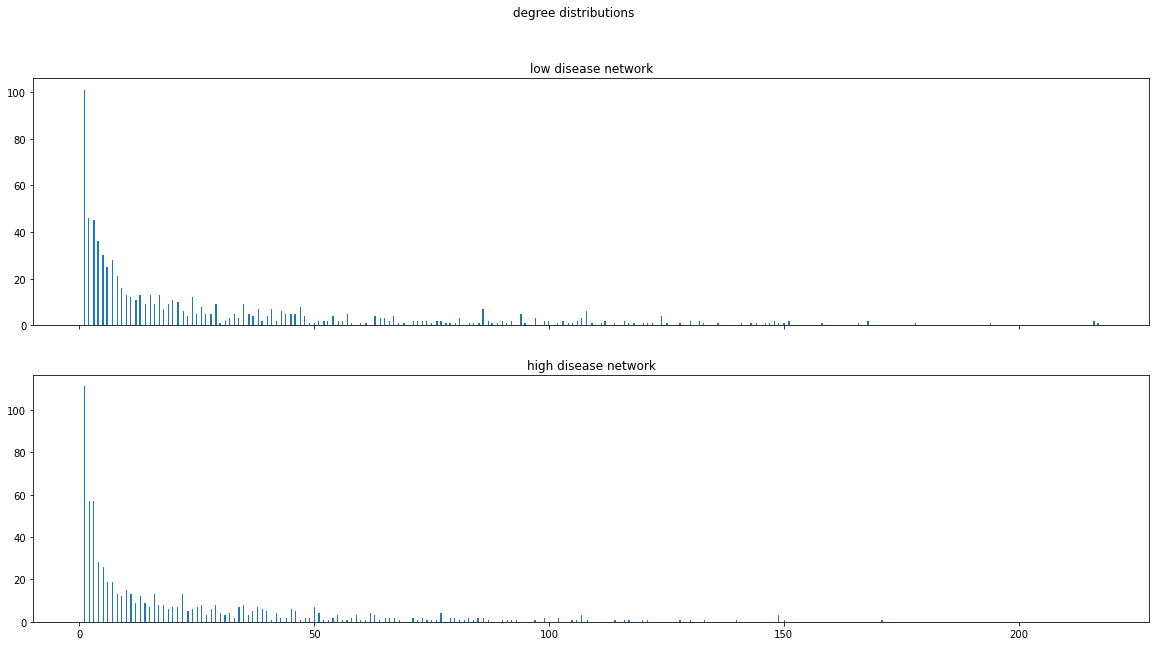

In [31]:
fig, ax = plt.subplots(2, sharex=True, figsize=(20,10))
lowAdjdegreez = [ i[1] for i in lowAdj.degree ]
ax[0].hist(lowAdjdegreez, log=False, bins=len(lowAdjdegreez))
ax[0].set_title('low disease network')
highAdjdegreez = [ i[1] for i in highAdj.degree ]
ax[1].hist(highAdjdegreez, log=False, bins=len(highAdjdegreez))
ax[1].set_title('high disease network')
fig.suptitle('degree distributions')


##### modularity

We'll try the "Clauset-Newman-Moore greedy modularity maximization" to delineate modules/communities in our networks, then use these to measure the modularity of the network:

In [32]:
lowAdj_communities_generator = community.greedy_modularity_communities(lowAdj)
lowAdj_communities = list(lowAdj_communities_generator)

highAdj_communities_generator = community.greedy_modularity_communities(highAdj)
highAdj_communities = list(highAdj_communities_generator)

In [33]:
print ("low-disease modularity = " + str(community.modularity(lowAdj, lowAdj_communities)))
print ("high-disease modularity = " + str(community.modularity(highAdj, highAdj_communities)))

low-disease modularity = 0.220912134375833
high-disease modularity = 0.24858977026069343


##### Mean clustering coefficient

In [34]:
mccLow = np.mean(list(networkx.clustering(lowAdj).values()))
mccHigh = np.mean(list(networkx.clustering(highAdj).values()))
print ("low-disease mean clustering coefficient = " + str(mccLow))
print ("high-disease mean clustering coefficient = " + str(mccHigh))

low-disease mean clustering coefficient = 0.3179890588662486
high-disease mean clustering coefficient = 0.29728532223421955


##### Betweenness centrality (CB)

In [35]:
cbLow = np.mean(list(networkx.betweenness_centrality(lowAdj).values()))
cbHigh = np.mean(list(networkx.betweenness_centrality(highAdj).values()))
print("low disease betweenness centrality = " + str(cbLow))
print("Betweenness centrality = " + str(cbHigh))

low disease betweenness centrality = 0.0023433754608529313
Betweenness centrality = 0.0028536647144458915


##### Closeness centrality (CC)

In [36]:
ccLow = np.mean(list(networkx.closeness_centrality(lowAdj).values()))
ccHigh = np.mean(list(networkx.closeness_centrality(highAdj).values()))
print("low disease closeness centrality = " + str(ccLow))
print("high disease closeness centrality = " + str(ccHigh))

low disease closeness centrality = 0.33727427009313143
high disease closeness centrality = 0.31036882641522184


Two other indices of interest are nestedness and indicator species. We go back to R for these:

##### Nestedness (WNODF)

##### Indicator species

In [ ]:
### Closeness centrality <CC>
ccLow = np.mean(list(networkx.closeness_centrality(lowAdj).values()))
ccHigh = np.mean(list(networkx.closeness_centrality(highAdj).values()))
print("low disease closeness centrality = " + str(ccLow))
print("high disease closeness centrality = " + str(ccHigh))


[back to top](#top)

High disease intensity

In [9]:
highPosAdjacency = pd.read_csv('highPosAdjacency.csv', index_col=0)
highAdj = networkx.from_pandas_adjacency(highPosAdjacency)


plot = figure(title="High Disease Network",
                x_range=(-1.1,1.1),
                y_range=(-1.1,1.1),
                )
graph = from_networkx(highAdj, networkx.fruchterman_reingold_layout, scale=2, center=(0,0))
graph.edge_renderer.glyph = MultiLine(line_color="#CCCCCC", line_alpha=0.4, line_width=2)
plot.renderers.append(graph)
show(plot)

All-sample network:

In [7]:
comboPosAdjacency = pd.read_csv('comboPosAdjacency.csv', index_col=0)
comboAdj = networkx.from_pandas_adjacency(comboPosAdjacency)
plot = figure(title="All-sample Network",
                x_range=(-1.1,1.1),
                y_range=(-1.1,1.1),
                )
graph = from_networkx(highAdj, networkx.fruchterman_reingold_layout, scale=2, center=(0,0))
graph.edge_renderer.glyph = MultiLine(line_color="#CCCCCC", line_alpha=0.4, line_width=2)
plot.renderers.append(graph)
show(plot)